# Scenario 4: Insight into mechanism by modelling 
Dataset provided by Sandile Ngubane (Department of Biotechnology and Food Technology, Durban University of Technology, Durban 4000, South Africa)  
  
In this scenario the oxidation of ABTS catalysed by Trametes pubescens laccase has been investigated. In contrast to the previous scenario, not only initial rates but the whole time-course data was modelled. 

## Imports
First all necessary Python packages must be installed and imported.  
This step is the same for all scenarios and differs only in the used python packages.
If you run this notebook with Binder you don't have to install anything, Binder takes care of this.   
If you run this notebook local make sure you have all Packages installed. All needed packages with the used version can be found in the `requirements.txt` in the root GitHub directory (not in `\book`).

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats
from scipy.integrate import odeint
from lmfit import minimize, Parameters, report_fit

from pyenzyme.enzymeml.core import EnzymeMLDocument, Protein, EnzymeReaction
from pyenzyme.enzymeml.models import KineticModel, KineticParameter

## Reading EnzymeML with PyEnzyme software <a class="anchor" name="ReadingEnzymeML"></a>
In order to read the EnzymeML document and access its content with the PyEnzyme software the file path is defined.  
When running the next code cell the EnzymeML document is saved in the `enzmlDoc` variable and an overview is printed below.

In [2]:
path = '../../data/Ngubane_ABTS_Measurements_orig.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLDocument.fromFile(path)
    enzmlDoc.printDocument()
else:
    raise FileNotFoundError(
        f'Couldnt find file at {path}.'
    )

ABTS_Measurement
>>> Reactants
	ID: s0 	 Name: 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulphonic acid)
	ID: s1 	 Name: oxygen
	ID: s2 	 Name: 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulphonic acid) radicals
	ID: s3 	 Name: H2O
>>> Proteins
	ID: p0 	 Name: laccase 2 (lap2)
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Oxidation


The overview shows which reactant corresponds to which id.  
Each measurement consists of 4 reactants (s0 - s3) and one protein (p0).  
In this case all 9 measurements were carried out under identical conditions and with varying initial concentrations of the substrate (s0). All concentration units are identical so no conversion is needed later on.     
Next, one measurement is exemplarily examined. 

In [3]:
# Fetch the measurement
measurement = enzmlDoc.getMeasurement('m0')
measurement.printMeasurementScheme()

>>> Measurement m0: Oxidation 1
    s0 | initial conc: 5.0 umole / l 	| #replicates: 3
    s1 | initial conc: 0.0 umole / l 	| #replicates: 0
    s2 | initial conc: 0.0 umole / l 	| #replicates: 0
    s3 | initial conc: 0.0 umole / l 	| #replicates: 0
    p0 | initial conc: 0.93 umole / l 	| #replicates: 0


The overview of the measurement shows that three replicates were measured for the substrate s0.

## Data preparation <a class="anchor" name="DataPreparation"></a>
In order to visualise and model the data, it first has to be extracted and prepared.  
All relevant data such as the initial concentrations and time-course data are extracted.

In [4]:
# define colors for time-course visualisation
colors9 = ['#252525','#999999','#f781bf','#984ea3','#ff7f00','#ffff33','#a65628','#4daf4a','#377eb8']
colors = []
# Substrate:
s0_init_conc = []
measured_data = []
# Protein:
p0_init_conc = []

# time and units
measurement = enzmlDoc.getMeasurement('m0')
time = measurement.global_time
time_unit = measurement.global_time_unit
conc_unit = ''

# go through all measurements:
for i, measurement in enumerate(enzmlDoc.measurement_dict.values()):
    
    # get replicates with time course data:
    reactant = measurement.getReactant('s0')
    conc_unit = reactant.unit
        
    for replicate in reactant.replicates:
        
        # Protein:
        p0_init_conc.append(measurement.getProtein('p0').init_conc)
        
        # Substrate:
        s0_init_conc.append(measurement.getReactant('s0').init_conc)
        measured_data.append(replicate.data)
        
        colors.append(colors9[i])

measured_data = np.array(measured_data)
p0_init_conc = np.array(p0_init_conc)
s0_init_conc = np.array(s0_init_conc)
time = np.array(time)

## Visualisation of time-course data
All time-course data is visualised with the Python library matplotlib.  
In order to save the figures as svg uncomment the `plt.savefig(...)` code lines. 

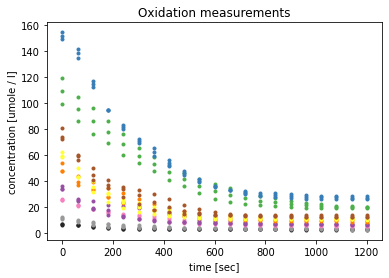

In [5]:
# get reaction name for the title of the visualisation
reaction_name = enzmlDoc.getReaction('r0').name
# plot time course data with matplotlib
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    ax.plot(time, measured_data[i, :],'o', ms=3, color=colors[i])
plt.title(reaction_name+' measurements')
xlabel = f"{'time'} [{time_unit}]"
ylabel = f"{'concentration'} [{conc_unit}]"
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
# plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

The visualisation shows the decrease of the substrate, ABTS unoxidised. After a standard course of the curves, which could correspond to Michaelis-Menten kinetics, the curves already flatten clearly above zero. This indicates that not all substrate was converted and the reactions my have stopped early.

## Kinetic modelling and parameter estimation
In order to model the data and perform parameter fitting, the kinetic equations for the models are defined as Python functions, along with a function to calculate the residual between the models and the measured data.  
In the following cell 3 different models are defined.  
First the irreversible Michaelis-Menten kinetic. 
Then, an extension of Michaelis-Menten with time-dependent enzyme inactivation. 
And last a Michaelis-Menten kinetic with substrate-dependent enzyme inactivation.  
Additional all kinetics contain a bias parameter, which will either be fixed to 0 or be an additional variable parameter for the model fitting.  
The Michaelis-Menten equation is an ordinary differential equation (ODE) describing the change of the substrate concentration over time. It is dependent on the available amount of substrate and enzymes to convert the substrate. In order to model the enzyme inactivation, the enzyme concentration is not held constant, but its concentration change is also described by a second ODE. Resulting in a system of coupled ODEs.  
The cell with the ODEs is followed by the code cell containing the computation of the residual between measured and modelled substrate concentration.

In [6]:
def irreversible_Michaelis_Menten(w, t, params):
    '''
    Differential equation of Michaelis-Menten model
    Arguments:
        w: vector of state variables: w = [c_S, c_E]
        t: time
        params: parameters object from lmfit
    '''
    c_S, c_E = w
    
    k_cat = params['k_cat'].value
    K_M = params['K_M'].value
    bias = params['bias'].value
    
    dc_S = -k_cat*c_E*(c_S-bias)/(K_M+c_S-bias)
    dc_E = 0
    
    return (dc_S, dc_E)

def menten_with_enzyme_inactivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [c_S, c_E]
        t: time
        params: parameters object from lmfit
    '''
    c_S, c_E = w
    
    k_cat = params['k_cat'].value
    K_M = params['K_M'].value
    k_i = params['k_i'].value
    bias = params['bias'].value
    
    dc_S = -k_cat*c_E*(c_S-bias)/(K_M+c_S-bias)
    dc_E = -k_i*c_E
    
    return (dc_S, dc_E)

def menten_with_substrate_dependent_enzyme_inactivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [c_S, c_E]
        t: time
        params: parameters object from lmfit
    '''
    c_S, c_E = w
    
    k_cat = params['k_cat'].value
    K_M = params['K_M'].value
    k_i = params['k_i'].value
    bias = params['bias'].value
    
    dc_S = -k_cat*c_E*(c_S-bias)/(K_M+c_S-bias)
    dc_E = -k_i*c_E*c_S
    
    return (dc_S, dc_E)

In [7]:
def residual(params, t, data, w, f):
    '''
    Calculates residual between measured data and modelled data

    Args:
        params: parameters object from lmfit
        t: time
        data: measured data
        w: vector of state variables [c_S, c_E]
        f: ODEs
    '''
    bias = np.array([params['bias'].value,0])
    w = np.add(w, bias)

    ndata = data.shape[0]
    residual = 0.0*data[:]
    for i in range(ndata):
        model = odeint(f, w[i], t, args=(params,))
        s_model = model[:,0]
        residual[i,:]=data[i,:]-s_model
    return residual.flatten()

### Initialising parameters
The Python library lmfit provides a parameter object to initialise the parameters before the fit. Initial values for all parameters must be given. Therefore the steepest slop of the curves is calculated to initialise k_cat. As an initial K_M the highest initial substrate concentration is taken, assuming the measurements took place in the range of K_Ms magnitude.

In [8]:
slopes = []
for i in range(measured_data.shape[0]):
    slope, intercept, r, p, se = stats.linregress(time[0:2], measured_data[i][0:2])
    slopes.append(abs(slope))
v_max = np.max(slopes)
c_E = p0_init_conc[0]
k_cat = v_max/c_E
K_M = np.max(s0_init_conc)

In [9]:
# Parameters for irreversible Michaelis-Menten without bias
params_MM = Parameters()
params_MM.add('k_cat', value=k_cat, min=0.0001, max=1000)
params_MM.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_MM.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with bias
params_MM_with_bias = Parameters()
params_MM_with_bias.add('k_cat', value=k_cat, min=0.0001, max=1000)
params_MM_with_bias.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_MM_with_bias.add('bias', value=0.1, min=0.0001, max=np.max(measured_data)*0.5)

In [10]:
# Parameters for Michaelis-Menten with time-dependent enzyme inactivation
params_time_dep_inactivation = Parameters()
params_time_dep_inactivation.add('k_i', value=0.5, min=0.00000001, max=np.max(measured_data))
params_time_dep_inactivation.add('k_cat', value=k_cat, min=0.0001, max=100)
params_time_dep_inactivation.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_time_dep_inactivation.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with time-dependent enzyme inactivation and bias
params_time_dep_inactivation_with_bias = Parameters()
params_time_dep_inactivation_with_bias.add('k_i', value=0.5, min=0.00000001, max=np.max(measured_data))
params_time_dep_inactivation_with_bias.add('k_cat', value=k_cat, min=0.0001, max=100)
params_time_dep_inactivation_with_bias.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_time_dep_inactivation_with_bias.add('bias', value=0, min=-0.00001, max=np.max(measured_data)*0.5)

In [11]:
# Parameters for Michaelis-Menten with substrate-dependent enzyme inactivation
params_sub_dep_inactivation = Parameters()
params_sub_dep_inactivation.add('k_i', value=0.5, min=0.00000001, max=np.max(measured_data))
params_sub_dep_inactivation.add('k_cat', value=k_cat, min=0.0001, max=100)
params_sub_dep_inactivation.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_sub_dep_inactivation.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with substrate-dependent enzyme inactivation and bias
params_sub_dep_inactivation_with_bias = Parameters()
params_sub_dep_inactivation_with_bias.add('k_i', value=1.4, min=0.00000001, max=np.max(measured_data))
params_sub_dep_inactivation_with_bias.add('k_cat', value=50, min=0.0001, max=100)
params_sub_dep_inactivation_with_bias.add('K_M', value=10000, min=0.0001, max=np.max(measured_data)*100)
params_sub_dep_inactivation_with_bias.add('bias', value=2, min=0.00001, max=np.max(measured_data)*0.5)

The fit for the last model would not yield any usable results for the tested initial parameter values, therefore these have been changed, by hand. 

### Model 1: Parameter fitting and results <a class="anchor" name="Model1"></a>
In the next cell the parameters for model 1 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

The fitting procedure is always the same. The differential equations are integrated by the odeint function of  SciPy. Then lmfit performs a curve-fitting by minimizing the residual with the least squares error method. 

In [12]:
results_dict = {}
# model 1: irreversible Michaelis-Menten
w = np.append(s0_init_conc, p0_init_conc).reshape((2,s0_init_conc.shape[0]))
w = np.transpose(w)
result_MM = minimize(residual, params_MM, args=(time, measured_data, w, irreversible_Michaelis_Menten), method='leastsq')
results_dict['irreversible Michaelis-Menten'] = result_MM

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 567
    # variables        = 2
    chi-square         = 19024.1974
    reduced chi-square = 33.6711458
    Akaike info crit   = 1995.93206
    Bayesian info crit = 2004.61278
[[Variables]]
    k_cat:  37.0324028 +/- 195.304874 (527.39%) (init = 0.3747312)
    K_M:    15438.9951 +/- 42767.4319 (277.01%) (init = 150)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M) = -1.000


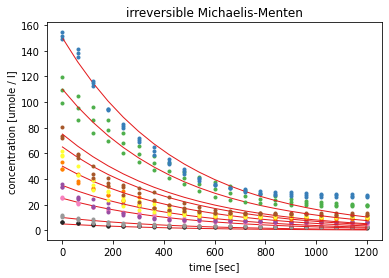

In [13]:
result = result_MM
report_fit(result)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted1 = odeint(irreversible_Michaelis_Menten, w[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted1[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('irreversible Michaelis-Menten')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model1.svg', bbox_inches='tight')
plt.show()

The fit statistics show that the errors for the estimated parameters are very high, exceeding 100%. The visualisation shows, that the model can describe the general course of the measured curves but the standard Michaelis-Menten kinetic, assumes complete conversion of the substrate, causing the curves to approach 0.  
Multiple runs of the fitting process with different initial parameter values and different boundaries for these, resulted all in higher K_M values as the given initial concentrations for the substrate.

### Model 2: Parameter fitting and results <a class="anchor" name="Model2"></a>
In the next cell the parameters for model 2 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [14]:
# model 2: Michaelis-Menten with bias
result_MM_with_bias = minimize(residual, params_MM_with_bias, args=(time, measured_data, w, irreversible_Michaelis_Menten), method='leastsq')
results_dict['irrev. Michaelis-Menten with bias'] = result_MM_with_bias

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 567
    # variables        = 3
    chi-square         = 18934.0263
    reduced chi-square = 33.5709686
    Akaike info crit   = 1995.23820
    Bayesian info crit = 2008.25928
[[Variables]]
    k_cat:  38.0326952 +/- 295.044691 (775.77%) (init = 0.3747312)
    K_M:    15438.9439 +/- 120415.718 (779.95%) (init = 150)
    bias:   0.65936449 +/- 0.43259950 (65.61%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M)  = 1.000
    C(K_M, bias)   = -0.531
    C(k_cat, bias) = -0.530


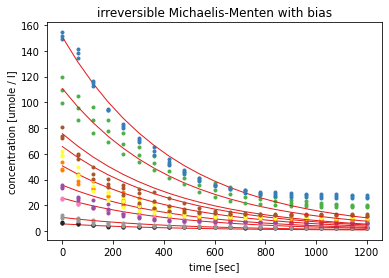

In [15]:
result = result_MM_with_bias
report_fit(result)
# add bias for visualisation
bias = np.array([result.params['bias'].value,0])
w2 = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted2 = odeint(irreversible_Michaelis_Menten, w2[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted2[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('irreversible Michaelis-Menten with bias')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model2.svg', bbox_inches='tight')
plt.show()

In the second model a static bis parameter was introduced in an attempt to reflect the end of the curves above zero. The errors of the estimated parameters stayed higher than 100% and the bias failed to reflect the different levels of remaining substrate concentration.

### Model 3: Parameter fitting and results <a class="anchor" name="Model3"></a>
In the next cell the parameters for model 3 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [16]:
# model 3: Michaelis-Menten with time-dependent enzyme inactivation
result_time_dep_inactivation = minimize(residual, params_time_dep_inactivation, args=(time, measured_data, w, menten_with_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten time-dep. enzyme inactivation'] = result_time_dep_inactivation

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 567
    # variables        = 3
    chi-square         = 9272.37264
    reduced chi-square = 16.4403770
    Akaike info crit   = 1590.44480
    Bayesian info crit = 1603.46588
[[Variables]]
    k_i:    0.00162999 +/- 7.1869e-05 (4.41%) (init = 0.5)
    k_cat:  1.50694647 +/- 0.16580205 (11.00%) (init = 0.3747312)
    K_M:    340.402549 +/- 46.9848874 (13.80%) (init = 150)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M) = 0.986
    C(k_i, K_M)   = -0.387
    C(k_i, k_cat) = -0.241


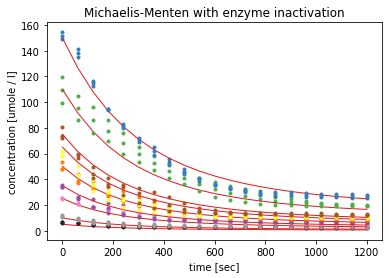

In [17]:
result = result_time_dep_inactivation
report_fit(result)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted3 = odeint(menten_with_enzyme_inactivation, w[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted3[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with enzyme inactivation')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model3.svg', bbox_inches='tight')
plt.show()

The third model with time-dependent enzyme inactivation yielded estimated parameters with errors in the range of 4 to 14%. The visualisation shows that the modelled curves in read follow the course of the measured substrate concentrations very closely.

### Model 4: Parameter fitting and results <a class="anchor" name="Model4"></a>
In the next cell the parameters for model 4 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [18]:
# model 4: Michaelis-Menten with time-dependent enzyme inactivation and bias
result_time_dep_inactivation_with_bias = minimize(residual, params_time_dep_inactivation_with_bias, args=(time, measured_data, w, menten_with_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten time-dep. enzyme inactivation and bias'] = result_time_dep_inactivation_with_bias


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 567
    # variables        = 4
    chi-square         = 8682.52530
    reduced chi-square = 15.4218922
    Akaike info crit   = 1555.17766
    Bayesian info crit = 1572.53910
[[Variables]]
    k_i:    0.00177123 +/- 7.3352e-05 (4.14%) (init = 0.5)
    k_cat:  1.04489418 +/- 0.08058435 (7.71%) (init = 0.3747312)
    K_M:    190.272492 +/- 22.7606295 (11.96%) (init = 150)
    bias:   2.02695341 +/- 0.31941453 (15.76%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M)  = 0.970
    C(K_M, bias)   = -0.652
    C(k_cat, bias) = -0.560
    C(k_i, K_M)    = -0.469
    C(k_i, bias)   = 0.326
    C(k_i, k_cat)  = -0.271


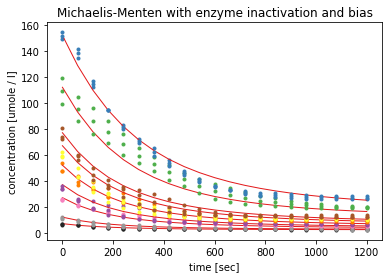

In [19]:
result = result_time_dep_inactivation_with_bias
report_fit(result)
# add bias for visualisation
bias = np.array([result.params['bias'].value,0])
w4 = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted4 = odeint(menten_with_enzyme_inactivation, w4[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted4[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with enzyme inactivation and bias')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model4.svg', bbox_inches='tight')
plt.show()

The fourth model with time-dependent enzyme inactivation and an additional bias parameter yielded to best fit statistics. The quality criterion, such as the Akaike information criterion had the lowest values, with corresponds to the best quality. As with model 3 the visualisation shows that the modelled red curves follow the measured concentrations. And the estimated K_M value of 190 µM seems to be more plausible than a K_M value of over 15000 µM as for model 1. 

### Model 5: Parameter fitting and results <a class="anchor" name="Model5"></a>
In the next cell the parameters for model 5 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [20]:
# model 5: Michaelis-Menten with substrate-dependent enzyme inactivation
result_substrate_dep_inactivation = minimize(residual, params_sub_dep_inactivation, args=(time, measured_data, w, menten_with_substrate_dependent_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten sub.-dep. enzyme inactivation'] = result_substrate_dep_inactivation


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 201
    # data points      = 567
    # variables        = 3
    chi-square         = 13943.5624
    reduced chi-square = 24.7226283
    Akaike info crit   = 1821.76868
    Bayesian info crit = 1834.78976
[[Variables]]
    k_i:    1.3847e-05 +/- 1.0131e-06 (7.32%) (init = 0.5)
    k_cat:  48.9872889 +/- 259.426829 (529.58%) (init = 0.3747312)
    K_M:    15438.9904 +/- 67909.9877 (439.86%) (init = 150)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M) = -1.000
    C(k_i, k_cat) = 0.323
    C(k_i, K_M)   = -0.319


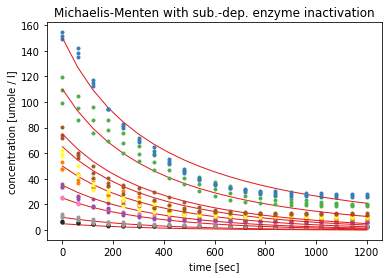

In [21]:
result = result_substrate_dep_inactivation
report_fit(result)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted5 = odeint(menten_with_substrate_dependent_enzyme_inactivation, w[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted5[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with sub.-dep. enzyme inactivation')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model5.svg', bbox_inches='tight')
plt.show()

While the substrate-dependent enzyme inactivation also models the course of the substrate concentration better than model 1, by approaching zero much slower, it does not fit as well as model 3 and 4. The red curves are not as flat after 1200 seconds as the course of the measured substrate concentration. Also the errors aof the estimated parameters again exceed 100% and the K_M value again becomes extremely large.

### Model 6: Parameter fitting and results <a class="anchor" name="Model6"></a>
In the next cell the parameters for model 6 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [22]:
# model 6: Michaelis-Menten with substrate-dependent enzyme inactivation and bias
result_substrate_dep_inactivation_with_bias = minimize(residual, params_sub_dep_inactivation_with_bias, args=(time, measured_data, w, menten_with_substrate_dependent_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten sub.-dep. enzyme inactivation and bias'] = result_substrate_dep_inactivation_with_bias

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 445
    # data points      = 567
    # variables        = 4
    chi-square         = 12182.0533
    reduced chi-square = 21.6377500
    Akaike info crit   = 1747.19301
    Bayesian info crit = 1764.55444
[[Variables]]
    k_i:    1.8380e-05 +/- 1.0762e-06 (5.86%) (init = 1.4)
    k_cat:  58.8805947 +/- 342.347158 (581.43%) (init = 50)
    K_M:    15438.5182 +/- 53446.5006 (346.19%) (init = 10000)
    bias:   2.84164163 +/- 0.34867450 (12.27%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M)  = 1.000
    C(K_M, bias)   = -0.512
    C(k_cat, bias) = -0.509
    C(k_i, bias)   = 0.309


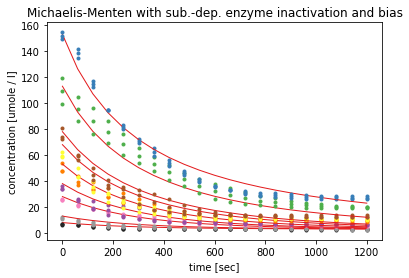

In [23]:
result = result_substrate_dep_inactivation_with_bias
report_fit(result)
# add bias for visualisation
bias = np.array([result.params['bias'].value,0])
w6 = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted6 = odeint(menten_with_substrate_dependent_enzyme_inactivation, w6[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted6[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with sub.-dep. enzyme inactivation and bias')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model6.svg', bbox_inches='tight')
plt.show()

After introducing the bias parameter again, the modelled curves seems to flatten a bit faster, but the fitting only yielded these curves after changing the initial values for the parameters. The estimated errors are still over 100%, with a K_M value of over 15000 µM.

### Table with estimated parameters for all models <a class="anchor" name="TableModels"></a>

The results for all models stored in the dictionary are taken and saved in a pandas dataframe which is shown as a table below. 

In [24]:
models_dataframe = pd.DataFrame()
for model_name, model_result in results_dict.items():
    for parameter_name, parameter_value in model_result.params.valuesdict().items():
        models_dataframe.loc[parameter_name,model_name] = round(parameter_value,1) if parameter_value > 1  else round(parameter_value,4)
models_dataframe

,irreversible Michaelis-Menten,irrev. Michaelis-Menten with bias,Michaelis-Menten time-dep. enzyme inactivation,Michaelis-Menten time-dep. enzyme inactivation and bias,Michaelis-Menten sub.-dep. enzyme inactivation,Michaelis-Menten sub.-dep. enzyme inactivation and bias
k_cat,37.0,38.0000,1.5000,1.0000,49.0,58.9
K_M,15439.0,15438.9000,340.4000,190.3000,15439.0,15438.5
bias,0.0,0.6594,0.0000,2.0000,0.0,2.8
k_i,NaN,NaN,0.0016,0.0018,0.0,0.0


## Discussion

Model 4 yielded the best quality criterion and the smallest estimated errors for the calculated parameters.  
The introduced k_i parameter describes the inactivation of the enzyme, and with the TODO add citation!!! equation $ t_{1/2} = \frac{\ln 2}{k_i}$ the half-life period can be calculated:

In [25]:
k_i = result_time_dep_inactivation_with_bias.params['k_i']
halfLifePeriod = np.log(2)/k_i/60
print(halfLifePeriod)

6.522288970041359


The model yielded a half-life-period of about 6.5 minutes.  
Since the modelling yielded K_M values higher than the initial substrate concentrations in this experiment, the project partners were advised to repeat the experiment with initial substrate concentrations between 100 and 500 µM if possible.  
In addition an experiment to further investigate the stability of the enzyme was recommended. This could be done similar to the experiment in Scenario 2, with a time-series of measurements.  
Furthermore, the fitting of model 5 and 6 showed, that the results are very dependent on the initial values for the parameters and the set bounds. Therefore, the minimization may only find local and not global minima. And reanalysis of any results with other methods or different initial values should be encouraged.

## Add model with estimated parameters to EnzymeML <a class="anchor" name="AddModel"></a>
Since we modelled two coupled differential equations we need to define a second reaction. In SBML each reaction can only be described by a single equation model. For this we will defined the reaction of the enzyme inactivation, with the active enzyme as substrate and the inactive enzyme as product.  
Therefore the inactive enzyme is defined in the next code cell.

In [26]:
# Copy the old Protein
params = enzmlDoc.getProtein('p0').dict()

# Create new Protein object, modify and add it
protein2 = Protein(**params)
protein2.name += " inactive"
protein2.init_conc = 0.0
protein2.constant = False

protein2_id = enzmlDoc.addProtein(protein2)

Now the second reaction is defined.

In [27]:
# Copy old reaction
params = enzmlDoc.getReaction('r0').dict()

# Create new Reaction
reaction2 = EnzymeReaction(**params)
reaction2.name = "Enzyme inactivation"
reaction2.reversible = True

# Add reaction elements
reaction2.addEduct('p0', 1.0, enzmlDoc)
reaction2.addProduct(protein2_id, 1.0, enzmlDoc)

# Finally, add it to the document
reaction2_id = enzmlDoc.addReaction(reaction2)

Next the kinetic model is defined with the differential equations and the estimated parameters.

In [28]:
equation_dsdt = "- k_cat * p0 * (s0 - bias) / (K_M + s0 - bias)"
equation_dedt = "- k_i * p0"

# parameters:
kcat_value = round(result_time_dep_inactivation_with_bias.params['k_cat'].value,2)
kcat_unit = f"1 / {time_unit}"

bias_value = round(result_time_dep_inactivation_with_bias.params['bias'].value, 2)
bias_unit = conc_unit

km_value = round(result_time_dep_inactivation_with_bias.params['K_M'].value,1)
km_unit = conc_unit

ki_value = round(result_time_dep_inactivation_with_bias.params['k_i'].value,4)
ki_unit = f"1 / {time_unit}"

# Create a model for the first reaction
k_cat = KineticParameter(name="k_cat", value=kcat_value, unit=kcat_unit)
k_m = KineticParameter(name="K_M", value=km_value, unit=km_unit)
bias = KineticParameter(name="bias", value=bias_value, unit=bias_unit)

kineticModel1 = KineticModel(
    name="Michaelis Menten with bias",
    equation=equation_dsdt,
    parameters=[k_cat, k_m, bias],
    enzmldoc=enzmlDoc
)

# Create model for the second reaction
k_i = KineticParameter(name="k_i", value=ki_value, unit=ki_unit)

kineticModel2 = KineticModel(
    name = "Enzyme inactivation",
    equation = equation_dedt, 
    parameters = [k_i],
    enzmldoc = enzmlDoc)

Finally the kinetic model is added to the reactions.

In [29]:
enzmlDoc.getReaction('r0').setModel(kineticModel1, enzmlDoc)
enzmlDoc.getReaction(reaction2_id).setModel(kineticModel2, enzmlDoc)

In order to write the EnzymeML document uncomment the next code line.

In [30]:
# enzmlDoc.toFile('../../data/', 'Ngubane_ABTS_Measurements_modelled')

## Upload to DaRUS <a class="anchor" name="Upload"></a>
Finally, the EnzymeML document is published on DaRUS and written to the current directory.   
In order to publish a dataset to DaRUS you need an API Token.  
If you want to publish set the `publish` variable to `True`. Then you will be asked for your API Token.

In [31]:
publish = False

In [32]:
if publish:
    API_Token = input('Enter API Token')

In [33]:
if publish:
    enzmlDoc.uploadToDataverse(
        baseURL="https://darus.uni-stuttgart.de/",
        API_Token= API_Token,
        dataverseName="enzymeml_at_work"
    )